# Setup

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
import albumentations as alb

# Loading Data

In [3]:
# !labelme

In [4]:
# for folder in ['train','test','val']:
#     for file in os.listdir(os.path.join('data', folder, 'images')):
        
#         filename = file.split('.')[0]+'.json'
#         existing_filepath = os.path.join('data','labels', filename)
#         if os.path.exists(existing_filepath): 
#             new_filepath = os.path.join('data',folder,'labels',filename)
#             os.replace(existing_filepath, new_filepath) 

In [5]:
# augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
#                          alb.HorizontalFlip(p=0.5), 
#                          alb.RandomBrightnessContrast(p=0.2),
#                          alb.RandomGamma(p=0.2), 
#                          alb.RGBShift(p=0.2), 
#                          alb.VerticalFlip(p=0.5)], 
#                         keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels']))

In [6]:
# for partition in ['train', 'test', 'val']: 
#     for image in os.listdir(os.path.join('data', partition, 'images')):
#         img = cv2.imread(os.path.join('data', partition, 'images', image))

#         classes = [0,0]
#         coords = [0,0,0.00001,0.00001]
#         label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
#         if os.path.exists(label_path):
#             with open(label_path, 'r') as f:
#                 label = json.load(f)
    
#             if label['shapes'][0]['label']=='LeftEye': 
#                 classes[0] = 1
#                 coords[0] = np.squeeze(label['shapes'][0]['points'])[0]
#                 coords[1] = np.squeeze(label['shapes'][0]['points'])[1]

#             if label['shapes'][0]['label']=='RightEye':
#                 classes[1] = 1
#                 coords[2] = np.squeeze(label['shapes'][0]['points'])[0]
#                 coords[3] = np.squeeze(label['shapes'][0]['points'])[1]

#             if len(label['shapes']) > 1:     
#                 if label['shapes'][1]['label'] =='LeftEye': 
#                     classes[0] = 1 
#                     coords[0] = np.squeeze(label['shapes'][1]['points'])[0]
#                     coords[1] = np.squeeze(label['shapes'][1]['points'])[1]

#                 if label['shapes'][1]['label'] =='RightEye': 
#                     classes[1] = 1
#                     coords[2] = np.squeeze(label['shapes'][1]['points'])[0]
#                     coords[3] = np.squeeze(label['shapes'][1]['points'])[1]
            
#             np.divide(coords, [640,480,640,480])
        
#         try: 
#             for x in range(120):
#                 keypoints = [(coords[:2]), (coords[2:])]
                
#                 augmented = augmentor(image=img, keypoints=keypoints, class_labels=['LeftEye','RightEye'])
                
#                 cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                
#                 annotation = {}
#                 annotation['image'] = image
#                 annotation['class'] = [0,0]
#                 annotation['keypoints'] = [0,0,0,0]

#                 if os.path.exists(label_path):
#                     if len(augmented['keypoints']) > 0: 
#                         for idx, cl in enumerate(augmented['class_labels']):
#                             if cl == 'LeftEye': 
#                                 annotation['class'][0] = 1 
#                                 annotation['keypoints'][0] = augmented['keypoints'][idx][0]
#                                 annotation['keypoints'][1] = augmented['keypoints'][idx][1]
#                             if cl == 'RightEye': 
#                                 annotation['class'][1] = 1 
#                                 annotation['keypoints'][2] = augmented['keypoints'][idx][0]
#                                 annotation['keypoints'][3] = augmented['keypoints'][idx][1]
                                
#                 annotation['keypoints'] = list(np.divide(annotation['keypoints'], [450,450,450,450]))


#                 with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
#                     json.dump(annotation, f)

#         except Exception as e:
#             print("error")

In [7]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    return img

In [35]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [36]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [37]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

In [38]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [39]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [40]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [41]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [42]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [43]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [44]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

In [45]:
arr = train.as_numpy_iterator().next()

In [46]:
X, y = train.as_numpy_iterator().next()
(X.shape, len(y[0]))

((16, 250, 250, 3), 16)

In [47]:
train.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.float16, name=None),))>

In [48]:
train = train.map(lambda x, y: (x, tf.reshape(y, (-1, 4))))
test = test.map(lambda x, y: (x, tf.reshape(y, (-1, 4))))
val = val.map(lambda x, y: (x, tf.reshape(y, (-1, 4))))

In [49]:
train.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float16, name=None))>

In [63]:
arr = train.as_numpy_iterator().next()

In [72]:
len(arr[0][0])

250

In [87]:
arr[1]

array([-17.110004 ,   1.7653855,  20.134602 ,   2.2607226], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


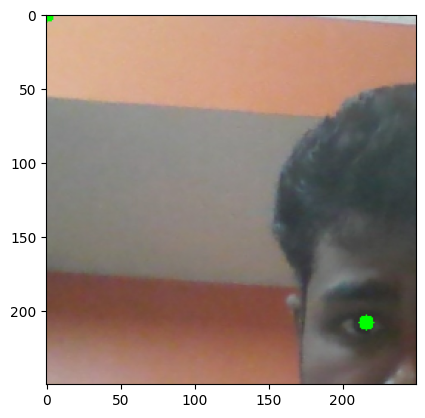

In [78]:
id = 5

x1 = arr[1][id][0]
y1 = arr[1][id][1]
x2 = arr[1][id][2]
y2 = arr[1][id][3]


# Create a copy of the image array
img_copy = arr[0][id].copy()

# Draw circle on the copy of the image
cv2.circle(img_copy, (int(x1*250), int(y1*250)), 5, (0,255,0), -1)
cv2.circle(img_copy, (int(x2*250), int(y2*250)), 5, (0,255,0), -1)
# Display the image
plt.imshow(img_copy)
plt.show()


# Build Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [95]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)), 
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'), # 3 is no fo filters, 2 is stride
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [96]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 8, 8, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 512)      │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 4, 4, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 2, 2, 256)      │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 1, 1, 4)        │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,575,556 (273.04 MB)

 Trainable params: 71,431,812 (272.49 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()

In [31]:
model.compile(optimizer, loss)

In [23]:
X, y = train.as_numpy_iterator().next()

In [24]:
X.shape

(16, 250, 250, 3)

In [35]:
coords = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


In [36]:
coords

array([[-1.0988334 , -0.937139  ,  0.5785758 ,  0.27695236],
       [-0.7272629 , -0.44095582,  0.20529863, -0.27524528],
       [-0.2461952 , -0.3703966 ,  0.13017589, -0.5925369 ],
       [-0.00965458, -0.65196574,  0.9950286 , -0.26375932],
       [ 0.09582379, -0.1868813 ,  0.13292393, -0.7039585 ],
       [-0.4830139 , -0.04267436,  0.847854  ,  0.5200611 ],
       [-0.32765582, -0.12800148,  0.20912513, -0.04420267],
       [-0.47795886, -0.34116483,  1.0996372 , -0.36462688],
       [-0.2814325 , -0.40179312,  0.22091725, -0.15861598],
       [-0.07606329, -0.4430104 ,  0.13714164,  0.08022345],
       [-0.07747319, -0.4593302 ,  0.26569366, -0.72026086],
       [-0.4006468 , -0.7264511 ,  0.23174149, -0.01971495],
       [-0.25949886,  0.5846646 ,  1.2204876 , -0.1958426 ],
       [-0.21981978, -0.279512  ,  0.7848282 ,  0.54583466],
       [-0.8699641 , -0.33530238, -0.37093082, -0.3704263 ],
       [-0.20787352, -0.77044797, -0.17059484,  0.16874331]],
      dtype=float32)

# Training

In [52]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [53]:
# hist = model.fit(train.take, epochs=20, validation_data=val) -> run this to get good model
hist = model.fit(train.take(1), epochs=1, validation_data=val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 787s 787s/step - loss: 0.4698 - val_loss: 111.1371


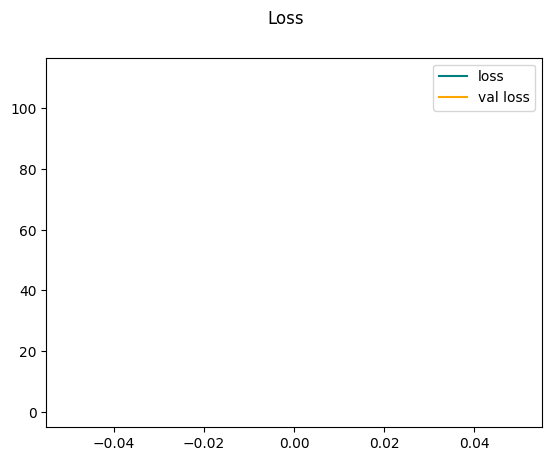

In [54]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

# Testing

In [55]:
test_data = test.as_numpy_iterator()

In [56]:
test_sample = test_data.next()

In [57]:
yhat = model.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [79]:
test_sample[0]

array([[[[0.83639216, 0.9548235 , 0.97411764],
         [0.8106667 , 0.9270588 , 0.96423525],
         [0.75529414, 0.8690196 , 0.9239216 ],
         ...,
         [0.587451  , 0.5992157 , 0.5717647 ],
         [0.579451  , 0.5888628 , 0.5661177 ],
         [0.5866667 , 0.5905883 , 0.56517655]],

        [[0.89239216, 0.99717647, 0.9990588 ],
         [0.86792153, 0.9764706 , 0.9934118 ],
         [0.81647056, 0.9254902 , 0.96549016],
         ...,
         [0.6133333 , 0.61803925, 0.58431375],
         [0.5797649 , 0.5915296 , 0.5549806 ],
         [0.5858823 , 0.5924705 , 0.5530982 ]],

        [[0.9192157 , 0.99764705, 0.9937255 ],
         [0.90588236, 0.99058825, 0.99529415],
         [0.8862745 , 0.9843137 , 1.        ],
         ...,
         [0.62352943, 0.6313726 , 0.5803922 ],
         [0.58823556, 0.5960787 , 0.546667  ],
         [0.5921569 , 0.5921569 , 0.54509807]],

        ...,

        [[0.7176471 , 0.7372549 , 0.72156864],
         [0.7254902 , 0.73333335, 0.72156864]

In [82]:
yhat

array([[-15.836633  ,   2.5753198 ,  18.563124  ,   1.129812  ],
       [-17.110004  ,   1.7653855 ,  20.134602  ,   2.2607226 ],
       [ -8.126088  ,   0.6319132 ,   9.794233  ,   0.78588825],
       [-13.155957  ,   2.5978758 ,  16.194801  ,   1.2772956 ],
       [-11.079508  ,   1.8735106 ,  13.379428  ,   1.5378115 ],
       [ -6.6900697 ,   0.94070405,   8.133495  ,   0.6521421 ],
       [ -9.60805   ,   1.44087   ,  11.7054    ,   0.468299  ],
       [ -7.235677  ,   0.869883  ,   8.631536  ,   0.8472059 ],
       [-16.267382  ,   1.4557097 ,  18.547573  ,   1.4734707 ],
       [ -8.065392  ,   1.5452571 ,   9.957721  ,   1.2710874 ],
       [-13.990361  ,   1.4152939 ,  16.556711  ,   1.2052402 ],
       [-16.197208  ,   2.3281033 ,  17.856867  ,   1.769557  ],
       [-17.190329  ,   3.1733398 ,  20.432632  ,   3.2196841 ],
       [ -6.494729  ,   0.88709724,   8.043277  ,   0.632912  ],
       [-11.336068  ,   1.2020015 ,  12.33079   ,   1.0732408 ],
       [-15.554756  ,   3

# Realtime Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()